# SWB Prospect Theory Modeling


Created: 01/13/2024 by Alie Fink
Updated: 01/14/2024

In [1]:
import numpy as np
import random
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize # minimize function is used for parameter recovery 
import seaborn as sns 
import tqdm
from scipy.stats import spearmanr
import statsmodels.api as sm
import os
from scipy.stats import norm
import pickle
import datetime
from joblib import Parallel, delayed
import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/')
import SWB_modeling_utils


### MLE Functions

In [5]:
##### MLE parameter estimation for base prospect theory
def fit_base_pt(params, subj_df, prior=None, output='mle'):

    risk_aversion, loss_aversion, inverse_temp = params

    if output == 'npl':
        risk_aversion = norm2riskaversion(risk_aversion) #transform parameter from gaussian space back into native model space using parameter-specific sigmoid function
        risk_aversion_bounds = [0.00001, 2] #set upper and lower bounds
        if risk_aversion< min(risk_aversion_bounds) or risk_aversion> max(risk_aversion_bounds): #prevent estimation from parameter values outside of bounds 
            return 10000000
        
        loss_aversion = norm2lossaversion(loss_aversion) #transform parameter from gaussian space back into native model space using parameter-specific sigmoid function
        loss_aversion_bounds = [0.00001, 6] #set upper and lower bounds
        if loss_aversion< min(loss_aversion_bounds) or loss_aversion> max(loss_aversion_bounds):  #prevent estimation from parameter values outside of bounds 
            return 10000000
        
        inverse_temp = norm2invtmp(inverse_temp) #transform parameter from gaussian space back into native model space using parameter-specific sigmoid function
        this_beta_bounds = [0.00001, 8]  #set upper and lower bounds
        if inverse_temp < min(this_beta_bounds) or inverse_temp > max(this_beta_bounds):  #prevent estimation from parameter values outside of bounds 
            return 10000000

    #Initialize choice probability vector to calculate negative log likelihood
        # actual subj choice info   
    choice_list = []
    choice_prob_list = []
        # predicted subj choice info 
    choice_pred_list = []
    choice_pred_prob = []

    #Initialize empty data vectors to return all relevant data if output = 'all'
    tr          = []
    trial_list  = []
    util_g      = []
    util_s      = []
    choice_util = []
    p_g         = []
    p_s         = []
    safe        = []
    high        = []
    low         = []
    w_safe      = []
    w_high      = []
    w_low       = []
    

    for trial in range(len(subj_df)):

        trial_info = subj_df.iloc[trial]
        trial_type = trial_info['TrialType']
        choice = trial_info['GambleChoice']
        high_bet = trial_info['HighBet']
        low_bet = trial_info['LowBet']
        safe_bet = trial_info['SafeBet']


        #store trial info 
        choice_list.append(choice)
        tr.append(trial)
        trial_list.append(trial_type)
        high.append(high_bet)
        low.append(low_bet)
        safe.append(safe_bet)

        ##### Utility calculations #####

        # transform to high bet value to utility (gamble)
        if high_bet > 0: #mix or gain trials
            weighted_high_bet = 0.5 * ((high_bet)**risk_aversion)
        else: #loss trials
            weighted_high_bet = 0 
        
        w_high.append(weighted_high_bet)

        # transform to low bet value to utility (gamble)
        if low_bet < 0: #loss and mix trials
            weighted_low_bet = -0.5 * loss_aversion * ((-low_bet)**risk_aversion)
            
        else: #gain trials
            weighted_low_bet = 0 
        
        w_low.append(weighted_low_bet)
        
        util_gamble = weighted_high_bet + weighted_low_bet
        util_g.append(util_gamble)
    

        # transform safe bet value to utility (safe)
        if safe_bet >= 0: #gain or mix trials
            util_safe = (safe_bet)**risk_aversion
        else: #loss trials
            util_safe = -loss_aversion * ((-safe_bet)**risk_aversion)

        w_safe.append(util_safe)
        util_s.append(util_safe)


        ##### Choice probability calculation #####

        # convert EV to choice probabilities via softmax
        p_gamble = np.exp(inverse_temp*util_gamble) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )
        p_safe = np.exp(inverse_temp*util_safe) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )

        p_g.append(p_gamble)
        p_s.append(p_safe)

        # append probability of chosen options
        if choice == 'gamble':
            choice_prob_list.append(p_gamble)
            choice_util.append(util_gamble)

        elif choice == 'safe':
            choice_prob_list.append(p_safe)
            choice_util.append(p_safe)
        
        
        #getting stochastic predictions of model 
        choice_pred = random.choices(['gamble','safe'],weights=[p_gamble,p_safe])[0]
        choice_pred_list.append(choice_pred)

        if choice_pred == 'gamble':
            choice_pred_prob.append(p_gamble)
        else:
            choice_pred_prob.append(p_safe)



    # calculate negative log likelihood of choice probabilities 
            
    negll = -np.sum(np.log(choice_prob_list))
    
    if np.isnan(negll):
        negll = np.inf
    
    # output for MLE optimization
    if output == 'mle': 
        return negll
    
    # output for fitting 
    elif output == 'all': 
        subj_dict = {'params'         : [risk_aversion, loss_aversion, inverse_temp],
                     'tr'             : tr,
                     'TrialType'      : trial_list,
                     'GambleChoice'   : choice_list,
                     'ChoiceProb'     : choice_prob_list,
                     'ChoiceUtil'     : choice_util,
                     'ChoicePred'     : choice_pred_list,
                     'ChoicePredProb' : choice_pred_prob,
                     'util_gamble'    : util_g,
                     'util_safe'      : util_s, 
                     'p_gamble'       : p_g,
                     'p_safe'         : p_s,
                     'HighBet'        : high,
                     'LowBet'         : low,
                     'SafeBet'        : safe,
                     'WeightedHigh'   : w_high,
                     'WeightedLow'    : w_low,
                     'WeightedSafe'   : w_safe,
                     'negll'          : negll,
                     'BIC'            : len(params) * np.log(150) + 2*negll,
                     'AIC'            : 2*len(params) + 2*negll}
        return subj_dict
    
    # output for EM MAP optimization
    elif output == 'npl':
        if prior is not None:  # EM-fit: P(Choices | h) * P(h | O) should be maximised, therefore same as minimizing it with negative sign
            fval = -(-negll + prior['logpdf'](params))

            if any(prior['sigma'] == 0):
                this_mu = prior['mu']
                this_sigma = prior['sigma']
                this_logprior = prior['logpdf'](params)
                print(f'mu: {this_mu}')
                print(f'sigma: {this_sigma}')
                print(f'logpdf: {this_logprior}')
                print(f'fval: {fval}')
            
            if np.isinf(fval): 
                fval = 10000000
            return fval
        else: # NLL fit 
            return negll
    


In [6]:
def minimize_negll(func_obj, param_values, df, param_bounds):
    # minimize negll via MLE via gradient descent

    result = minimize(func_obj, 
                      param_values, 
                      df,
                      bounds=param_bounds)
    return result

In [7]:
def parallel_run_base_pt(min_fn, fit_fn,param_combo_guesses,param_bounds,subj_df,n_jobs=-2):
    '''
    Maximum likelihood estimation with parallel processing 

    Inputs:
        - min_fn: minimization function 
        - fit_fn: model fitting function (should return negll only)
        - param_combo_guesses: grid of initial param values for parallel min_fn runs 
        - param_bounds: min/max bounds for params in this format: (0,5),(0,5),(0,10)
        - subj_df: pandas df of subj task data
    
    Returns:
        - fit_dict: output of fit_fn

    '''

    
    ##### Minimize negll via parallel mle

    # Parallel fn :
        # Basic syntax Parallel(n_jobs,verbose) ( delayed(optim_fn)(optim_fun inputs) loop for parallel fn inputs )
        # requires Parallel & delayed from joblib
        # n_jobs=-2 - num cpus used, -1 for all, -2 for all but one, +num for specific num
        # verbose default is none, higher than 10 will give all
        # delayed() = hold memory for function to run in parallel
        # optim_fn = minimization fn
        # ()() = inputs for optim_fn in delay - negll fn, params, data, bounds
        # (()()____): iterations of initial param values 
    
    results = Parallel(n_jobs=n_jobs, verbose=5)(delayed(min_fn)(fit_fn, param_values, (subj_df), param_bounds) for param_values in param_combo_guesses)

    # determine optimal parameter combination from negll
    fit_dict = {}
    best_result = min(results, key=lambda x: x.fun) # use lambda function to get negll from each run in results (lambda args: expression) 
    param_fits = best_result.x
    fit_dict['best_result'] = best_result
    # run fit_fn with param_fits get best model fit info ### implement this with GLMs!
    fit_dict['subj_dict'] = fit_fn(param_fits, subj_df, output='all')
    
    
    return fit_dict

# Run mle optimization base pt

In [8]:
# set directories
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
# load subj_id info
behav_dir = f'{base_dir}behavior_analysis/behavior_preprocessed/'
subj_list = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0],engine='openpyxl') #SWB subj that meet all inclusion criteria
subj_ids = list(subj_list.PatientID)
# get date info for data/fig saving
date = datetime.date.today().strftime('%m%d%Y')

In [10]:
#loading behavior data as list of pandas dfs 
behav_dict = {}
for subj_id in subj_ids:
    df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
    behav_dict[subj_id] = df

In [11]:
# Create grid of initial values for minimization (parallel_run_base_pt runs each initial value combo in parallel)

risk_inits     = np.linspace(.1,1.75,4)
loss_inits     = np.linspace(.1,5,4)
invtemp__inits = np.linspace(.75,8,4)
print(risk_inits,loss_inits,invtemp__inits)


[0.1  0.65 1.2  1.75] [0.1        1.73333333 3.36666667 5.        ] [0.75       3.16666667 5.58333333 8.        ]


In [12]:
#### run MLE optimization

swb_pt_MLE_dict = {}
# specify param bounds (risk_aversion, loss_aversion, inverse_temperature)
param_bounds = ((0.00001, 2), (0.00001, 6), (0.00001, 10))

for subj_id in subj_ids:
    # make grid of param values > itertools object disappears if used? 
    param_combo_guesses = itertools.product(risk_inits,loss_inits,invtemp__inits)
    subj_df = behav_dict[subj_id]
    subj_fit_dict = parallel_run_base_pt(minimize_negll, fit_base_pt, param_combo_guesses, param_bounds, subj_df, n_jobs=-2)
    swb_pt_MLE_dict[subj_id] = subj_fit_dict
    print('Best fit negll =  ', subj_fit_dict['subj_dict']['negll'])

swb_pt_MLE_dict


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   16.0s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   55.47638747871123


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   10.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   81.63458551456212


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   20.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   90.21543173049923


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   16.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   96.9296419655421


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   16.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   91.02284696175519


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   21.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   88.98490402643435


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   19.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   95.56006024713037


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   24.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   88.14989862166999


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:    9.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   85.85759016494117


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   21.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   100.32748836959462


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   18.6s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   18.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   97.60850081650108


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   13.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   92.17995055041771


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:    9.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   90.14867796366354


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   21.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   87.03407022254021


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   14.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   66.9089070884844


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:    9.5s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   76.95942305993955


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   15.9s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   94.54391766707832


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   13.9s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   80.04161891092156


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   14.7s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   60.11898044130548


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   14.9s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   78.67117746066629


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   13.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   83.09260925778914


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   20.8s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   95.14704375313246


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   11.0s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   52.99967671452373


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   10.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   100.01223713719179


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   17.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   90.2266203436264


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   11.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Best fit negll =   71.60037605295093


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   13.5s finished


Best fit negll =   98.92680520255412


{'DA8': {'best_result':   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
    success: True
     status: 0
        fun: 55.47638747871123
          x: [ 1.212e+00  5.111e+00  2.626e+00]
        nit: 21
        jac: [ 1.421e-06  0.000e+00  7.105e-07]
       nfev: 172
       njev: 43
   hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>,
  'subj_dict': {'params': [1.2121208765838623,
    5.111117405714725,
    2.6255574959860715],
   'tr': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    6

In [11]:
swb_pt_MLE_dict.keys()

dict_keys(['DA8', 'DA9', 'DA10', 'DA11', 'DA023', 'DA026', 'MS002', 'MS003', 'MS004', 'MS016', 'MS017', 'MS019', 'MS020', 'MS022', 'MS025', 'MS026', 'MS027', 'MS029', 'MS030', 'MS033', 'MS035'])

In [13]:
#### save estimation dict 
save_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/'
os.makedirs(save_dir,exist_ok = True) 

# create a binary pickle file 
f = open(f'{save_dir}swb_pt_MLE_dict_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(swb_pt_MLE_dict,f)
# # close file
f.close()


# Parameter Exploration

In [14]:
### load pickle dicts
save_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/'
swb_pt_MLE_dict = pickle.load(open(f'{save_dir}swb_pt_MLE_dict_{date}.pkl', 'rb' ) )


In [14]:
#### create fig saving directory
fig_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/figs/swb_pt_mle_fits/'
os.makedirs(fig_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y') #add date to file name --- update every run!


%matplotlib inline

#### set theme for all plots
sns.set_theme(style='ticks',font='Arial') 
sns.set_context("talk")

In [15]:
# extract estimated params for all subj
risk_est    = []
loss_est    = []
invtemp_est = []


for subj_id in subj_ids: 
    subj_data = swb_pt_MLE_dict[subj_id]['subj_dict']
    risk_est.append(subj_data['params'][0])
    loss_est.append(subj_data['params'][1])
    invtemp_est.append(subj_data['params'][2])


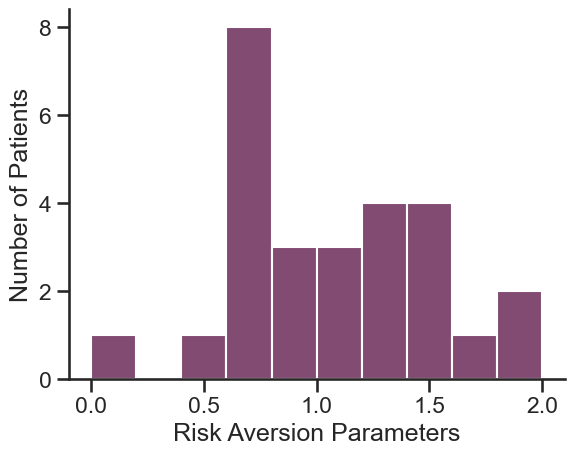

In [16]:
#### histogram of risk aversion parameter values 

# Create a histogram
fig, ax = plt.subplots()
sns.histplot(data=risk_est, color = '#580F41',bins=10)

# Set the xlabel and ylabel properties of the axes object
ax.set_xlabel('Risk Aversion Parameters')
ax.set_ylabel("Number of Patients")
sns.despine()


plt.savefig(f'{fig_dir}risk_aversion_mle_estimates_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

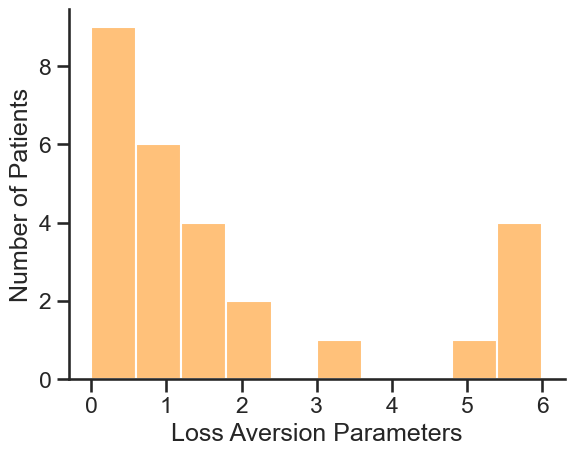

In [17]:
#### histogram of loss aversion parameter values 

# Create a histogram
fig, ax = plt.subplots()
sns.histplot(data=loss_est, color = '#ffac4d',bins=10)

# Set the xlabel and ylabel properties of the axes object
plt.xlabel('Loss Aversion Parameters')
ax.set_ylabel("Number of Patients")
sns.despine()


plt.savefig(f'{fig_dir}loss_aversion_mle_estimates_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 



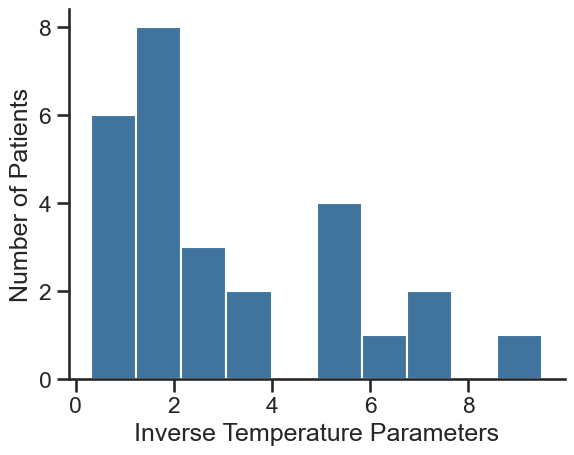

In [19]:
#### histogram of inv temp parameter values 

# Create a histogram
fig, ax = plt.subplots()
sns.histplot(data=invtemp_est, color = '#00467e',bins=10)

# Set the xlabel and ylabel properties of the axes object
plt.xlabel('Inverse Temperature Parameters')
ax.set_ylabel("Number of Patients")
sns.despine()


plt.savefig(f'{fig_dir}inverse_temperature_mle_estimates_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


### Parameter x BDI correlations


In [20]:
### Test SWB BDI

#get swb bdi and bai 
raw_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_raw/'
subj_bdi = []
for subj_id in subj_ids:
    raw_data_dir = f'{raw_dir}{subj_id}/'
    raw_data_files = os.listdir(raw_data_dir)
    #load task data
    #load swb bdi and bai info to add to mood df
    raw_bdi_name = [x for x in raw_data_files if 'BDI' in x] #not all subj have BDI
    if raw_bdi_name:
        raw_bdi = pd.read_table(raw_data_dir+raw_bdi_name[0]) 
        bdi = raw_bdi['BDI Score'].iloc[-1]   
    else:
        bdi = 0
    subj_bdi.append(bdi)

# subj_bdi


In [21]:
subj_bdi_param_info = list(zip(subj_ids,subj_bdi,risk_est,loss_est,invtemp_est))
subj_bdi_param_info

[('DA8', 13, 1.2121208765838623, 5.111117405714725, 2.6255574959860715),
 ('DA9', 32, 1.4843855350868347, 0.8368550319245323, 3.2610527820822592),
 ('DA10', 11, 0.7817682194629577, 1.7271898775934866, 3.058601637146079),
 ('DA11', 41, 1.1996248942296537, 0.22625527088567746, 1.5277504652135365),
 ('DA023', 14, 0.994607529853195, 1.8643805718376236, 2.089040827073733),
 ('DA026', 19, 0.5649501071646357, 2.148783622731296, 2.429444154268669),
 ('MS001', 24, 1.1505827066750531, 1e-05, 2.058961425188988),
 ('MS002', 14, 0.8170529213668378, 3.421696904925692, 1.3872466569920145),
 ('MS003', 8, 0.7331236600985406, 1e-05, 5.115220150425162),
 ('MS004', 7, 0.7110229010177544, 6.0, 0.3169792223047625),
 ('MS009', 16, 1.236864622058619, 1.7179302635927112, 1.1077059476355195),
 ('MS011', 13, 1.4342201304525535, 1.2823882899026484, 1.5948777829352432),
 ('MS015', 26, 1.2131095193659034, 1e-05, 2.1331269074053054),
 ('MS016', 10, 0.6237596060605469, 0.9697373802065534, 6.760218243166692),
 ('MS017

In [22]:
highbdi_subj_param_info = []
lowbdi_subj_param_info = []

highbdis = []
lowbdis = []

highbdi_risk = []
lowbdi_risk = []

highbdi_loss = []
lowbdi_loss = []

highbdi_invtemp = []
lowbdi_invtemp = []

for s in range(len(subj_ids)):
    info = subj_bdi_param_info[s]
    bdi = info[1]
    if bdi >= 20:
        highbdi_subj_param_info.append(info)
        highbdis.append(bdi)
        highbdi_risk.append(info[2])
        highbdi_loss.append(info[3])
        highbdi_invtemp.append(info[4])
    else:
        lowbdi_subj_param_info.append(info)
        lowbdis.append(bdi)
        lowbdi_risk.append(info[2])
        lowbdi_loss.append(info[3])
        lowbdi_invtemp.append(info[4])


In [23]:
risk_corr, risk_p = spearmanr(subj_bdi,risk_est)
print('Spearman correlation: %.3f' % risk_corr)
print(risk_p)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Spearman correlation: 0.140
0.48682947116484254


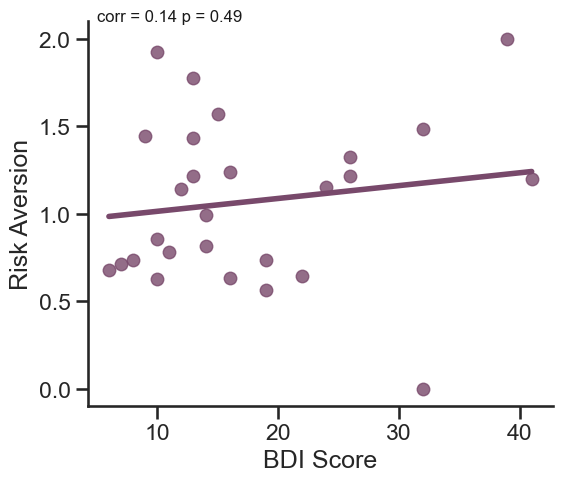

In [24]:
# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=subj_bdi, y=risk_est,color = '#78496b',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(5, 2.1,f'corr = {np.round(risk_corr,2)} p = {np.round(risk_p,2)}',fontsize=12,color = 'k')
plt.xlabel('BDI Score')
plt.ylabel('Risk Aversion')
sns.despine()


plt.savefig(f'{fig_dir}risk_aversion_mle_bdi_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [25]:
loss_corr, loss_p = spearmanr(subj_bdi,loss_est)
print('Spearman correlation: %.3f' % loss_corr)
print(loss_p)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Spearman correlation: -0.365
0.06137072771848155


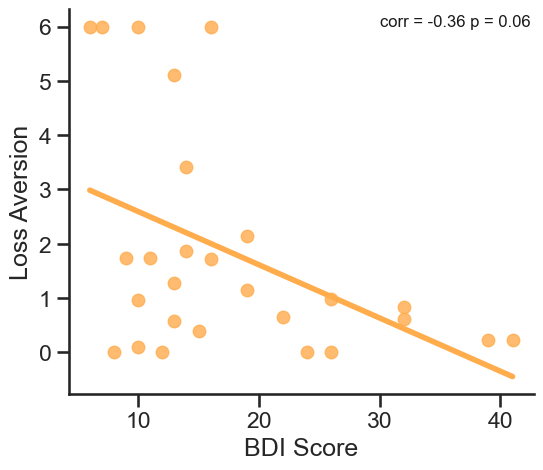

In [26]:
# plt.scatter(subj_bdi,loss_est,color = '#ffac4d')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=subj_bdi, y=loss_est,color = '#ffac4d',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(30, 6,f'corr = {np.round(loss_corr,2)} p = {np.round(loss_p,2)}',fontsize=12,color = 'k')
plt.xlabel('BDI Score')
plt.ylabel('Loss Aversion')
sns.despine()


plt.savefig(f'{fig_dir}loss_aversion_mle_bdi_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [27]:
invtemp_corr, invtemp_p = spearmanr(subj_bdi,invtemp_est)
print('Spearman correlation: %.3f' % invtemp_corr)
print(invtemp_p)

Spearman correlation: 0.116Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

0.5647616104798379


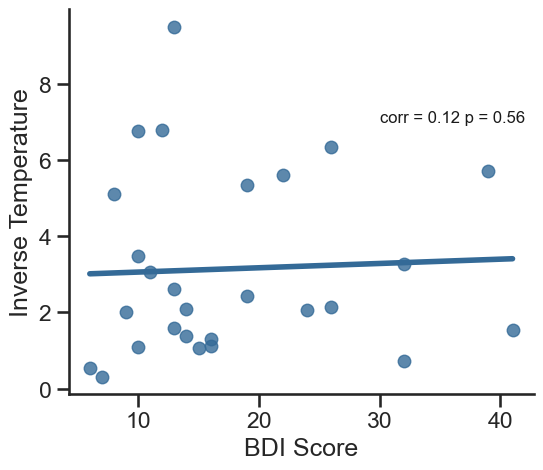

In [28]:
# plt.scatter(subj_bdi,invtemp_est,color = '#346a97')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=subj_bdi, y=invtemp_est,color = '#346a97',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(30, 7,f'corr = {np.round(invtemp_corr,2)} p = {np.round(invtemp_p,2)}',fontsize=12,color = 'k')
plt.xlabel('BDI Score')
plt.ylabel('Inverse Temperature')
sns.despine()



plt.savefig(f'{fig_dir}invtemp_mle_bdi_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)